In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import  files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import read_saved_epochs, Data_Splitter
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.articulated_human_poses import pc_loader as pose_loader

from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from pc_completions.evaluation import basic_comletion_measures

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
do_training = True
first_time_running = True
load_model = False
load_epoch = None
seed = 42
top_data_dir = '/orions4-zfs/projects/optas/DATA'

# train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_10_2048pts_emd')
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/human_articulation_all_data_2048_pts_bneck_16_chamfer')
# human_articulation_all_data_no_max_2048_pts_bneck_16_chamfer

In [13]:
# Load complete Point-Clouds of single class (Shape-Net)
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = [f for f in files_in_subdirs(pclouds_path, '.ply')]
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(file_names=file_names, n_threads=50, loader=snc_loader)
assert(len(np.unique(syn_ids)) == 1)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds, labels=model_ids)

6778 files containing complete point clouds were found.


In [5]:
# Load complete Point-Clouds of Poses
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Articulated_Mesh_Animations/', str(n_pc_points))
file_names = [f for f in files_in_subdirs(pclouds_path, '.ply')]
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(file_names=file_names, n_threads=50, loader=pose_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds, labels=model_ids)

2000 files containing complete point clouds were found.


In [7]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
print conf
if conf.train_dir != train_dir:
    conf.train_dir = train_dir
conf.save(osp.join(train_dir, 'configuration'))

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm': True, 'layer_sizes': [1024, 2048, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'filter_sizes': [20, 10, 10, 5], 'n_filters': [64, 128, 256, 16], 'b_norm': True, 'strides': [1, 1, 2, 2]}
               experiment_name: human_articulation_all_data_2048_pts_bneck_16_chamfer
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 20
                     train_dir: /orions4-zfs/p

In [8]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
if load_epoch is None: # load last saved.
    saved_epochs = read_saved_epochs(conf.train_dir)
    load_epoch = saved_epochs[-1]        
ae.restore_model(conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 680.


In [23]:
subset = []
for i, l in enumerate(train_data.labels):
    if l.startswith('samba'):
        subset.append(i)
np.random.seed(42)
rids = np.random.choice(subset, 20, replace=False)

In [10]:
pclouds_to_check = train_data.point_clouds[rids]

In [148]:
new_shape = [ae.bottleneck_size] + list(pclouds_to_check.shape)
grad_signal = np.zeros(shape=new_shape)

for dim in range(ae.bottleneck_size):
    grad_signal[dim] = ae.gradient_of_input_wrt_latent_code(pclouds_to_check, [dim])

In [149]:
abs_sum_grad = np.sum(abs(grad_signal), -1)

In [11]:
from geo_tool import Cuboid

65


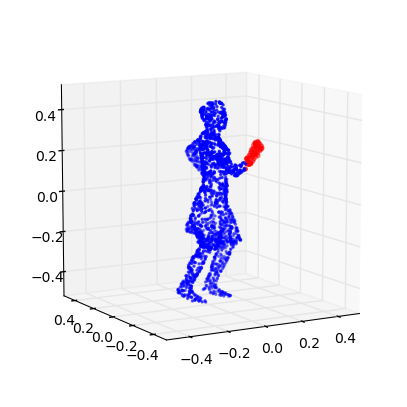

In [58]:
cb = Cuboid([0.09, -0.2, 0.1,   0.2, 0, 0.3])
ind_of_cub = []
for point in pclouds_to_check[0]:
    ind_of_cub.append(cb.is_point_inside(point))
ind_of_cub = np.array(ind_of_cub)
print np.sum(np.array(ind_of_cub))
fig = Point_Cloud(pclouds_to_check[0][ind_of_cub, :]).plot(show=False, s=30, color='r');
ax = fig.get_axes()[0]
Point_Cloud(pclouds_to_check[0][ind_of_cub==False, :]).plot(axis=ax)

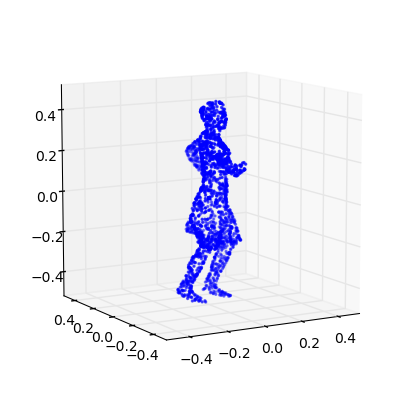

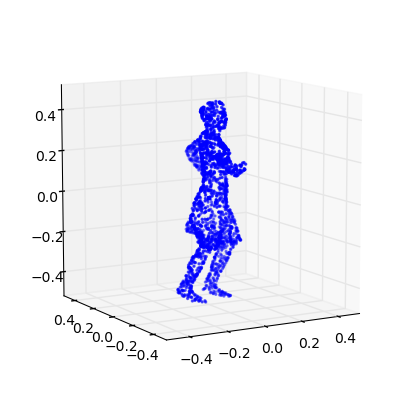

In [80]:
prtb = pclouds_to_check[0].copy()
prtb[ind_of_cub] = [0, 0, 0]
Point_Cloud(prtb).plot()

In [90]:
z_src_orig = ae.transform(np.expand_dims(pclouds_to_check[0], 0))

z_src_prtb = ae.transform(np.expand_dims(prtb, 0))

diff = z_src_orig - z_src_prtb

z_trg_orig = ae.transform(np.expand_dims(pclouds_to_check[1], 0))

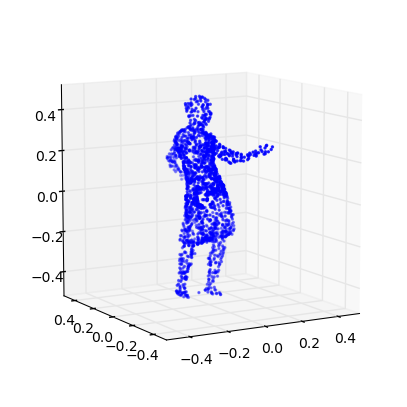

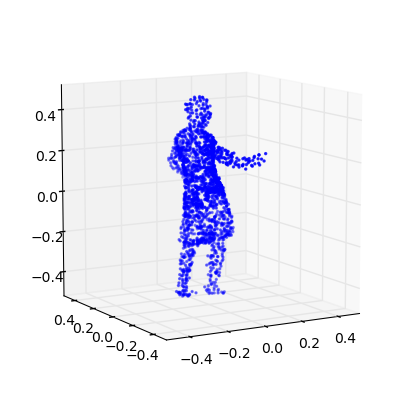

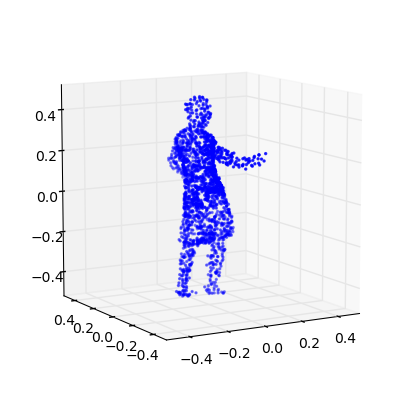

In [91]:
Point_Cloud(ae.decode(z_trg_orig)[0]).plot()
Point_Cloud(ae.decode(z_trg_orig-diff)[0]).plot()

74 89


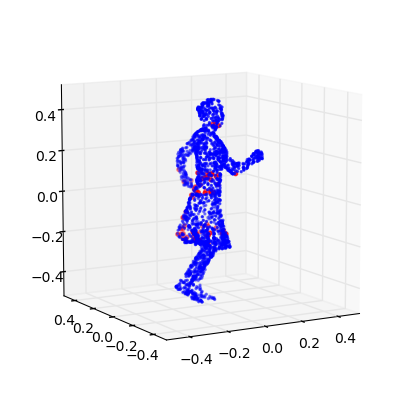

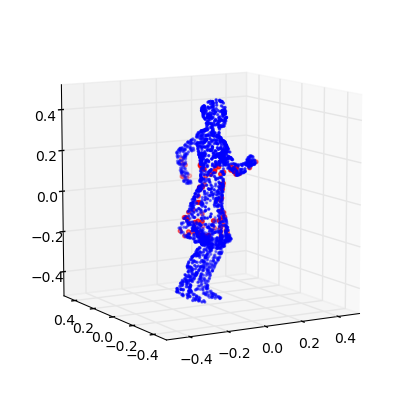

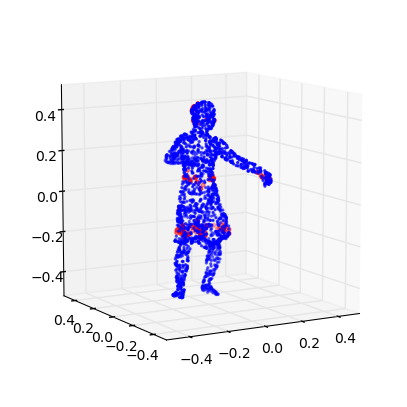

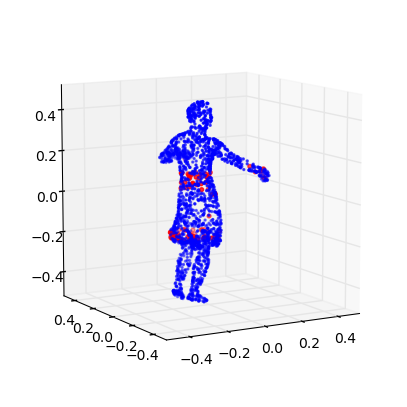

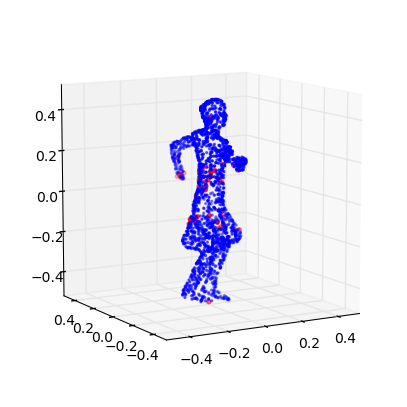

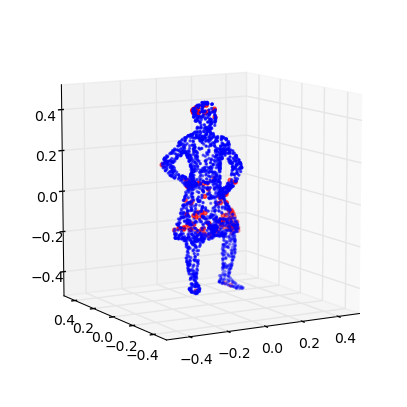

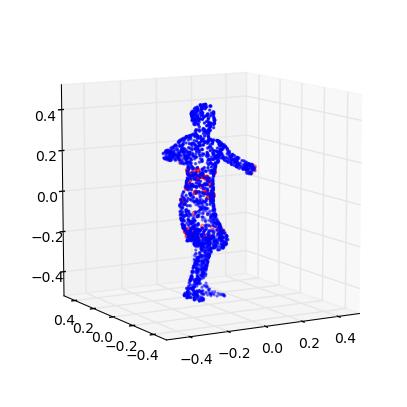

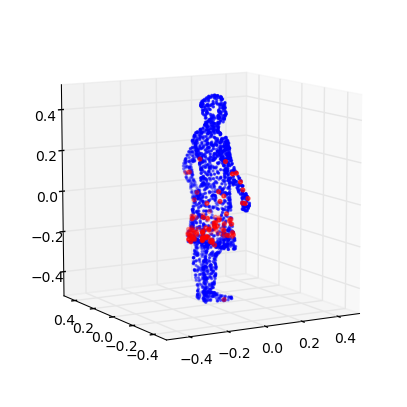

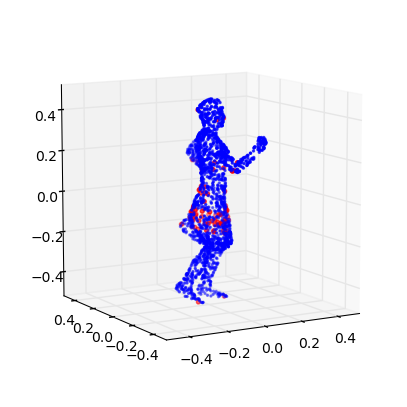

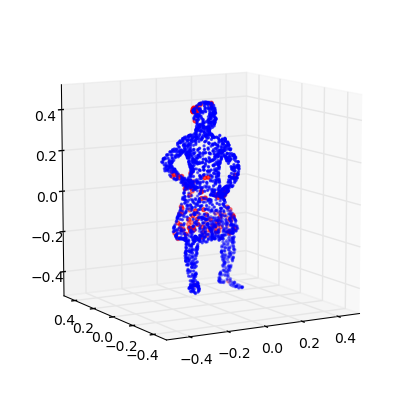

In [163]:
k = 10
print np.sum(indicators[0, :, k]), np.sum(indicators[1, :, k])
for pc in range(10):
    fig = Point_Cloud(pclouds_to_check[pc][indicators[pc, :, k], :]).plot(show=False, s=30, color='r');
    ax = fig.get_axes()[0]
    Point_Cloud(pclouds_to_check[pc][indicators[pc, :, k]==False, :]).plot(axis=ax)

In [66]:
unique_activation_patterns = dict()
counter = 1
for i in range(len(indicators)):
    for row in indicators[i]:
        if not tuple(row) in unique_activation_patterns:
            unique_activation_patterns[tuple(row)] = counter
            counter += 1

print 'Unique-patterns = ', len(unique_activation_patterns)

Unique-patterns =  87


In [67]:
color = np.zeros(indicators.shape[:-1])
for i in range(len(indicators)):
    for j, row in enumerate(indicators[i]):
        color[i,j] = unique_activation_patterns[tuple(row)]

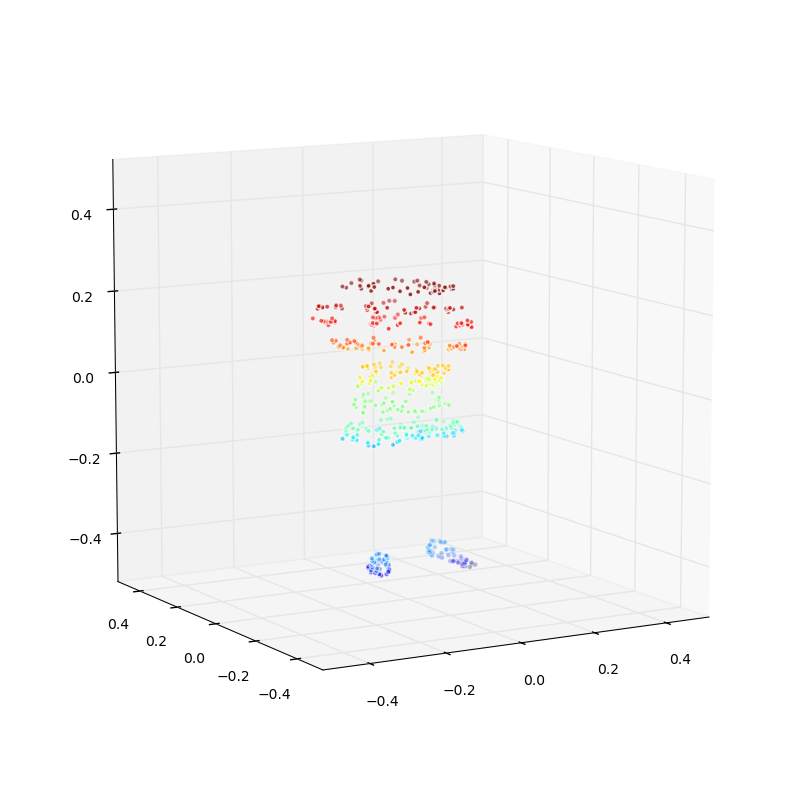

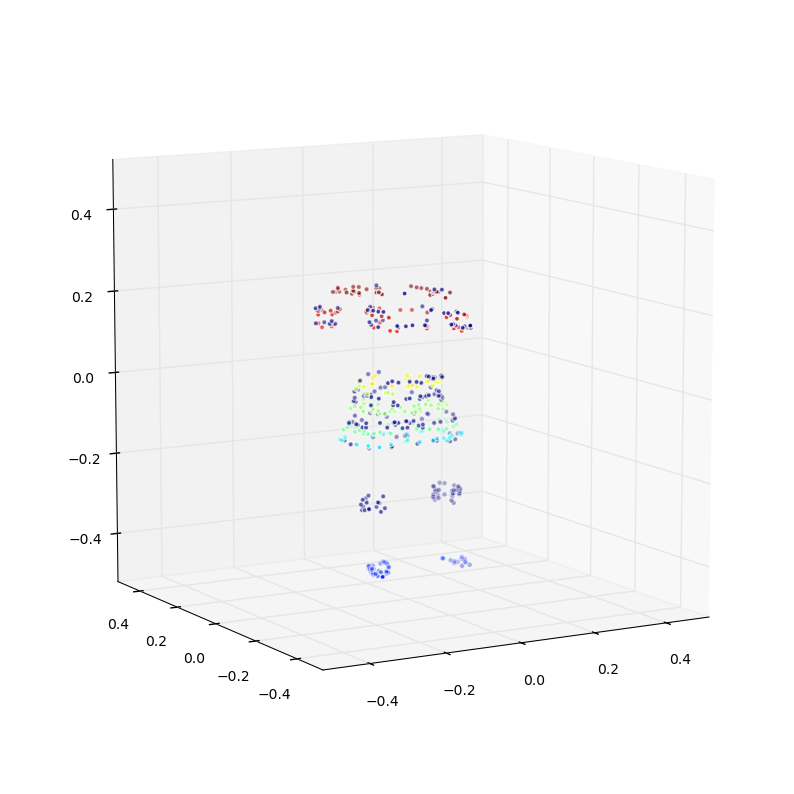

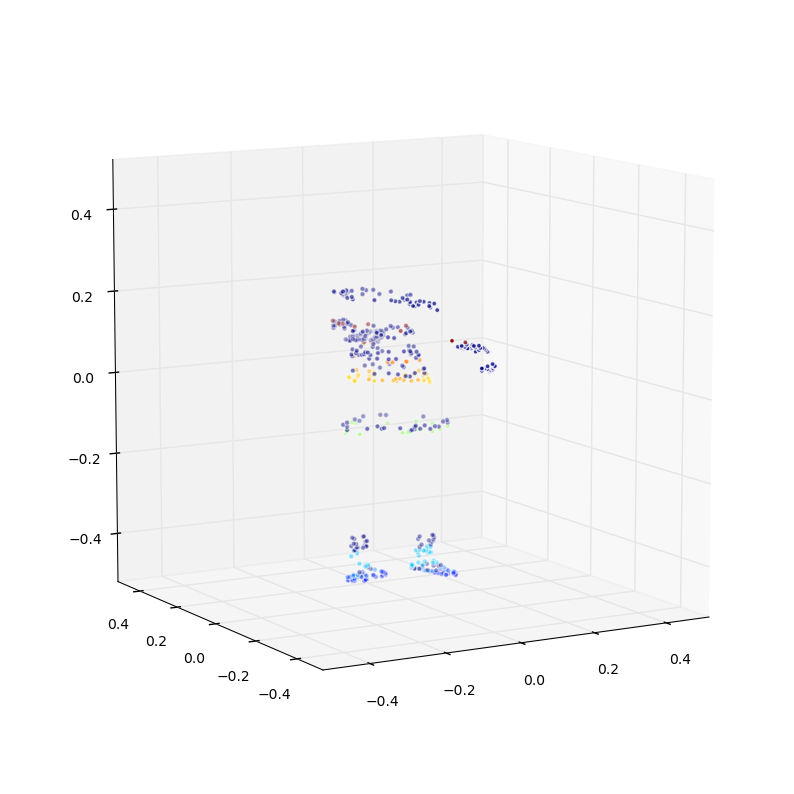

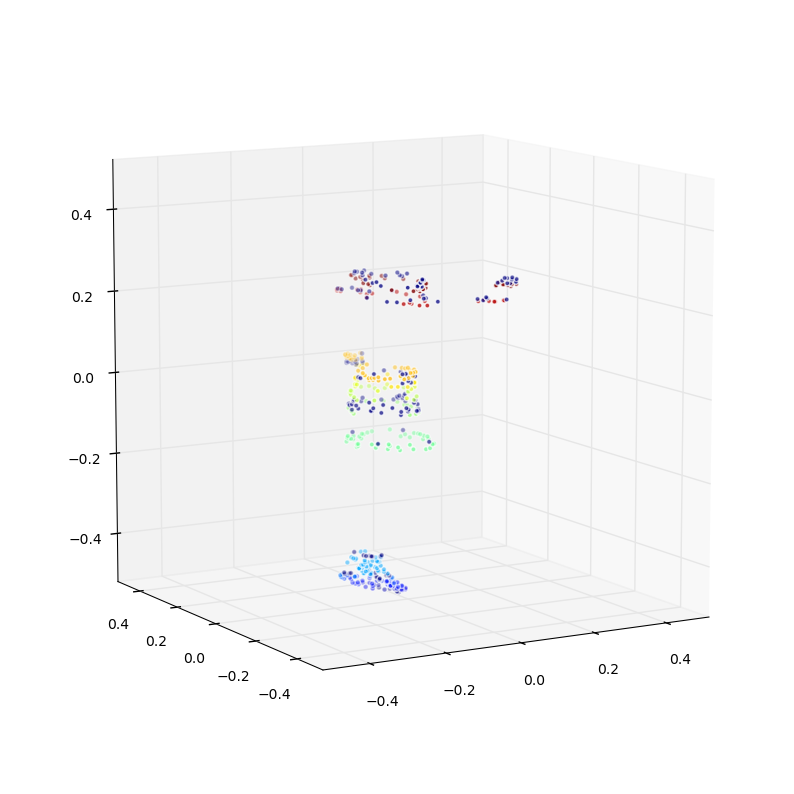

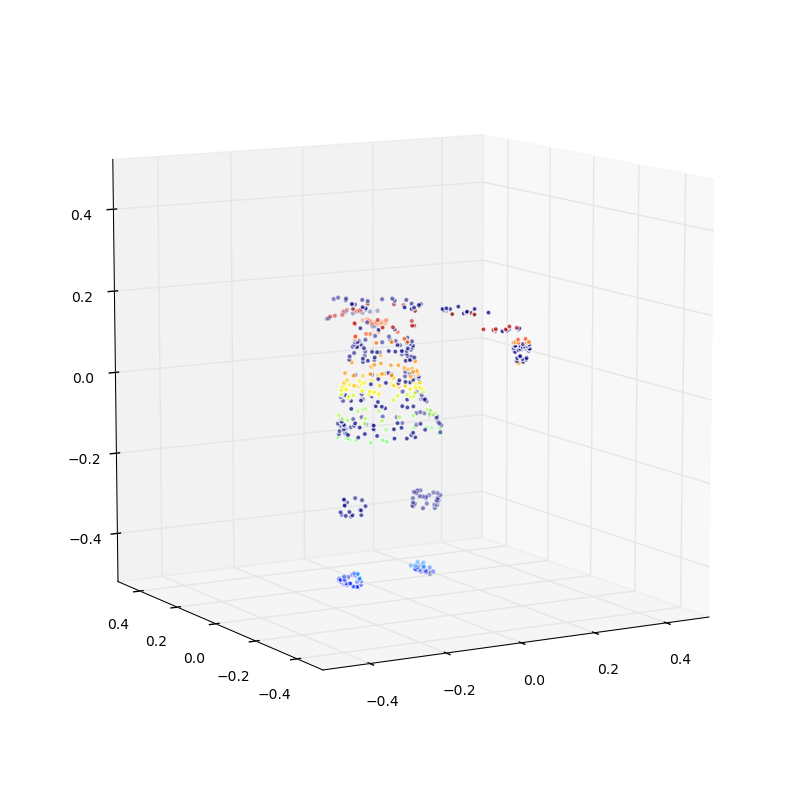

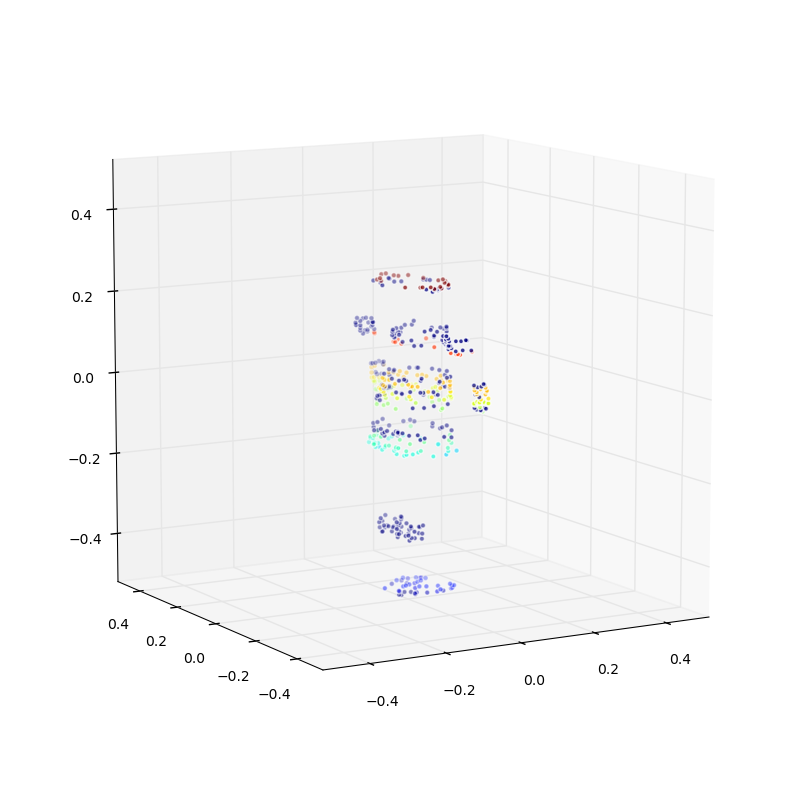

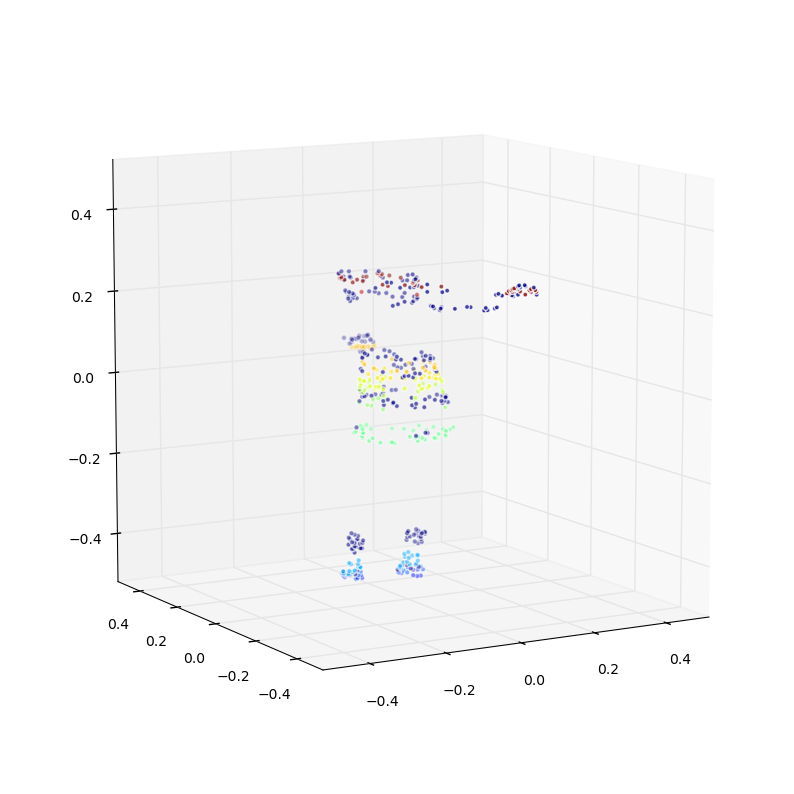

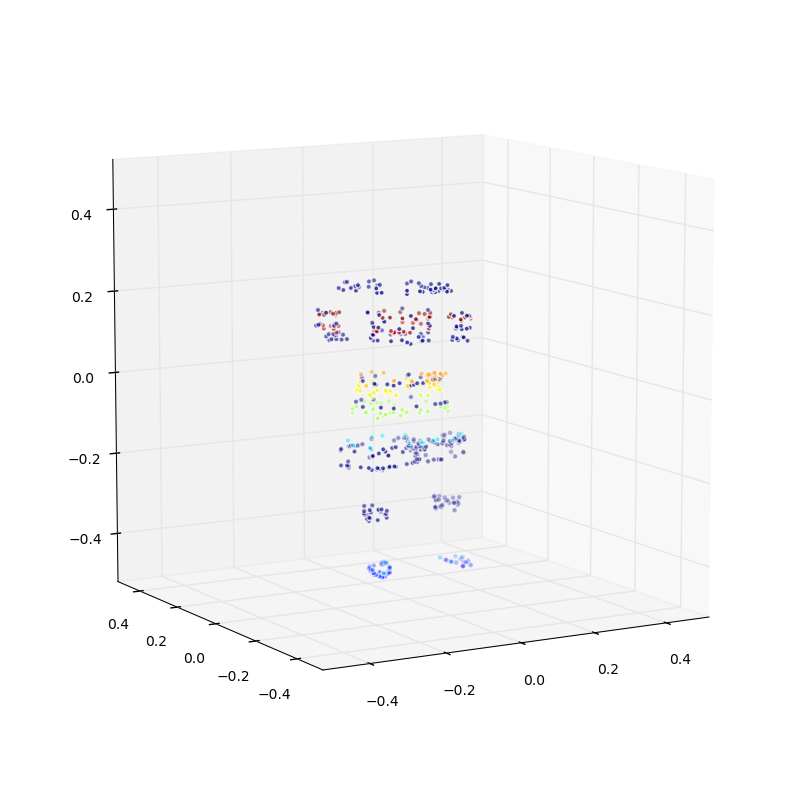

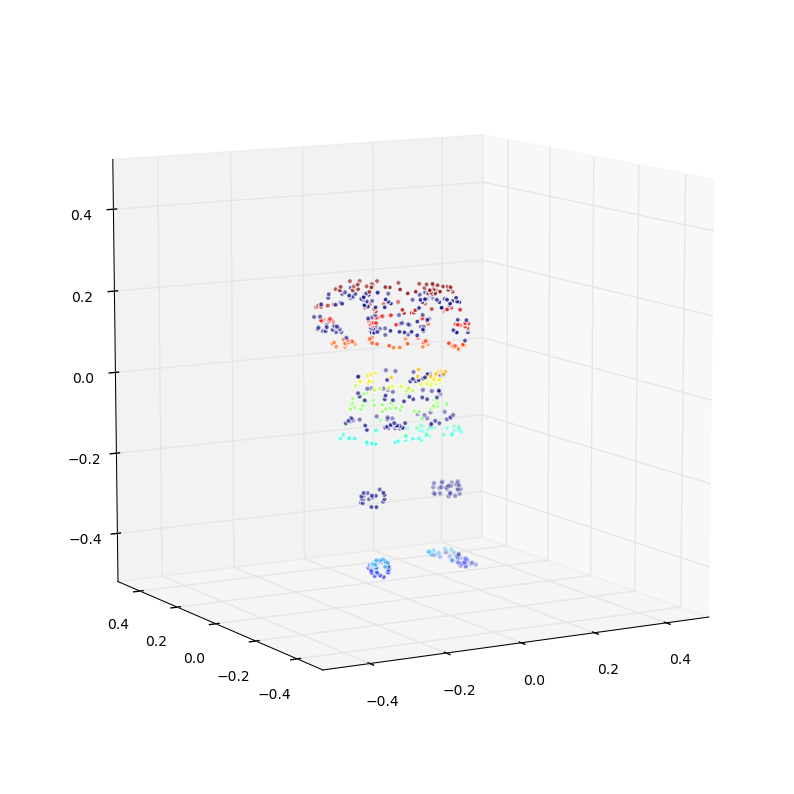

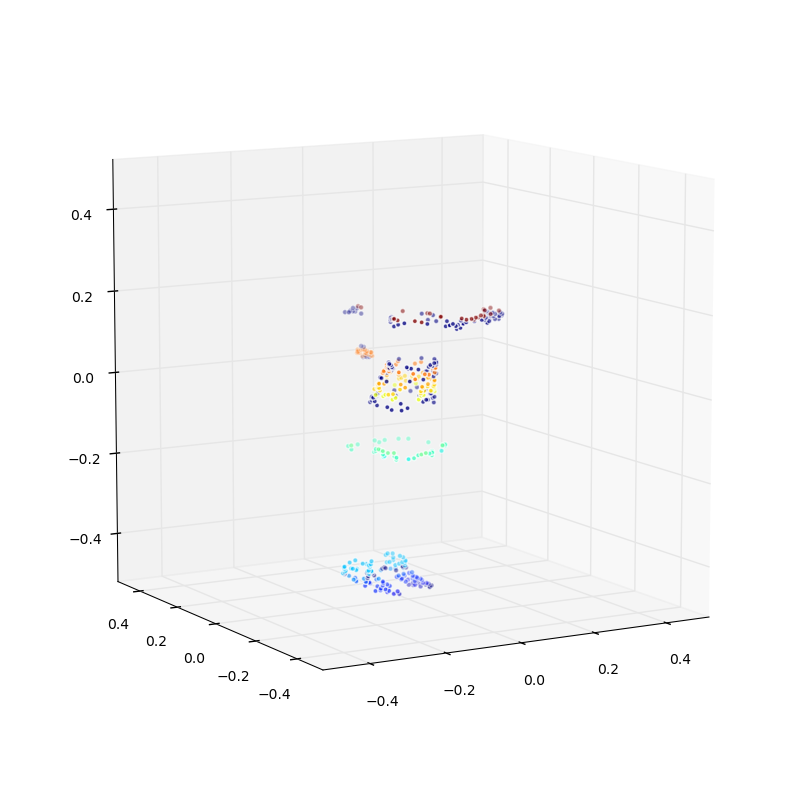

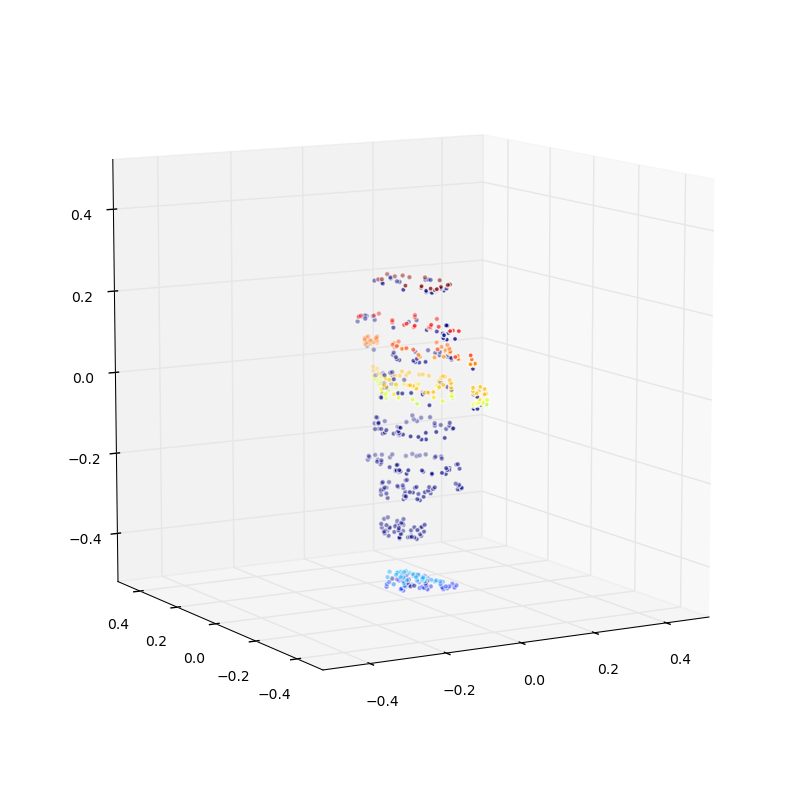

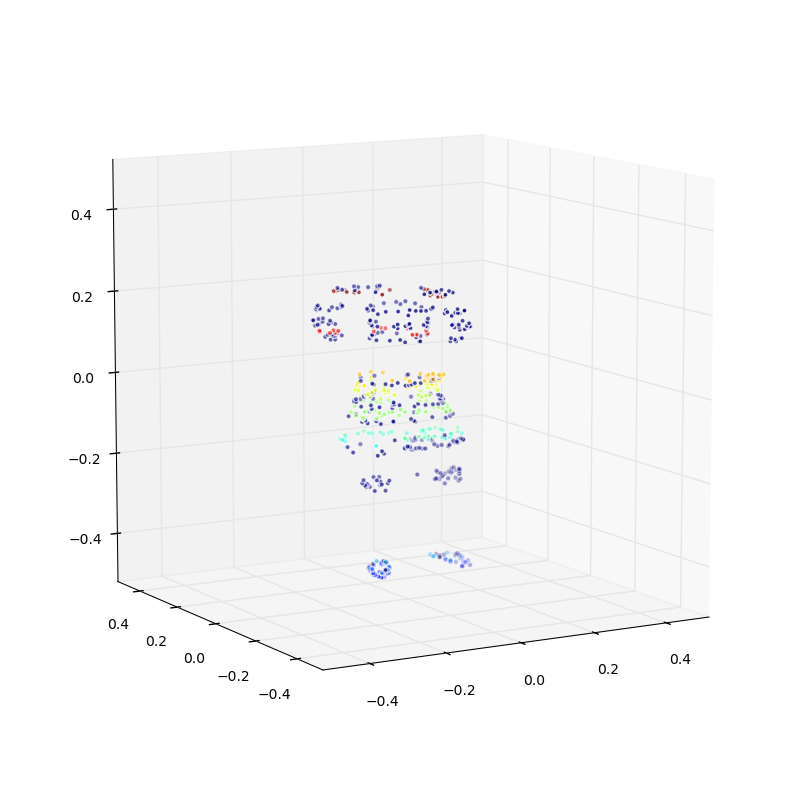

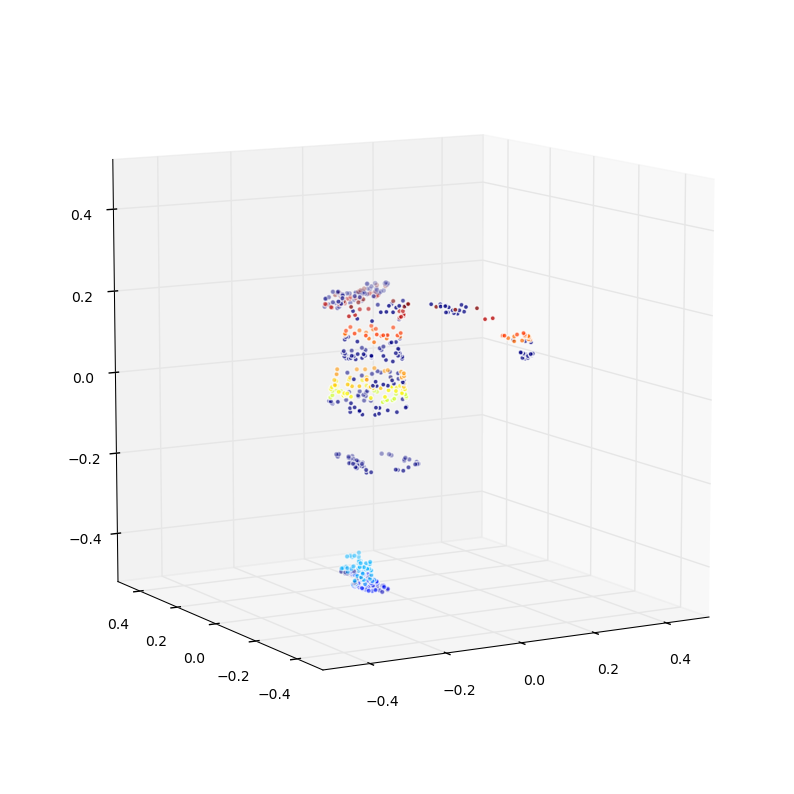

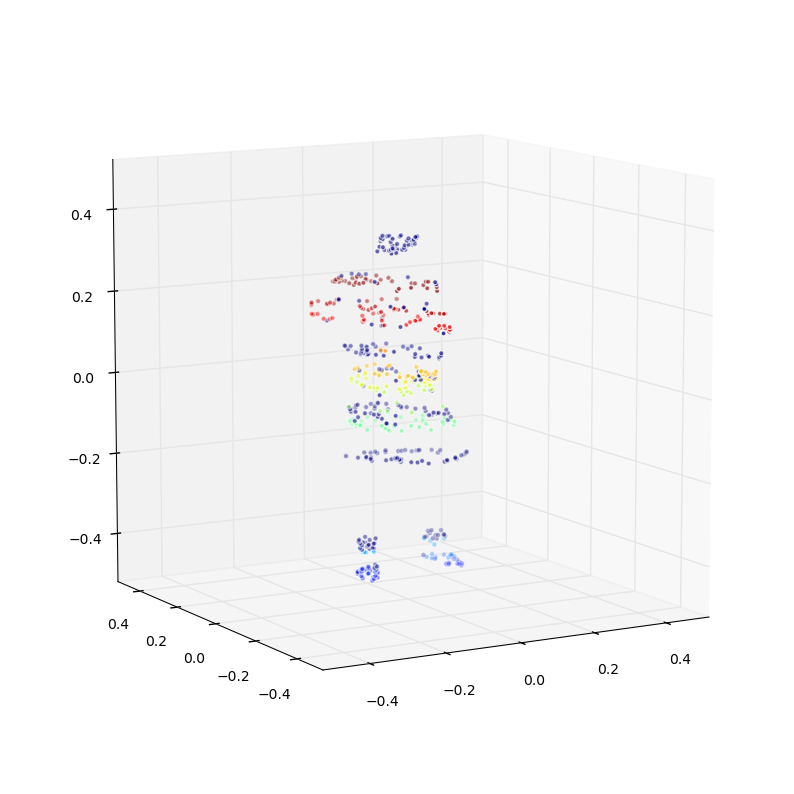

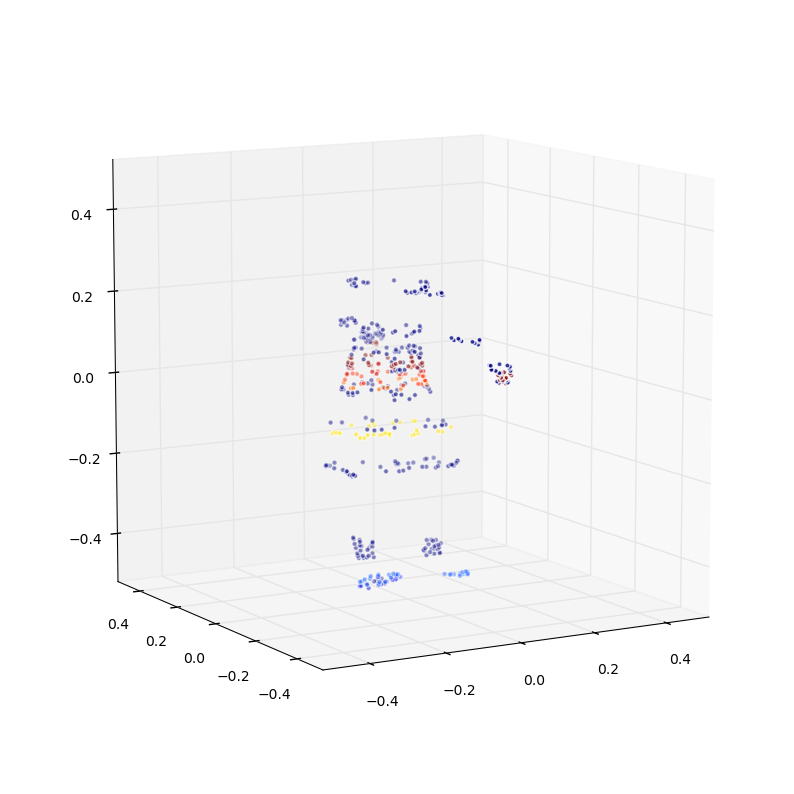

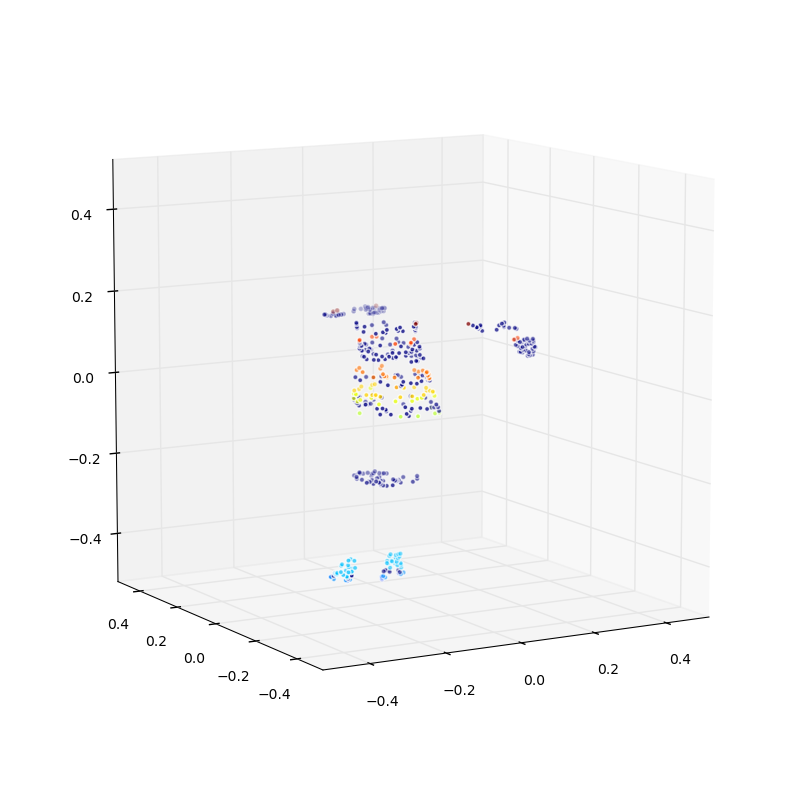

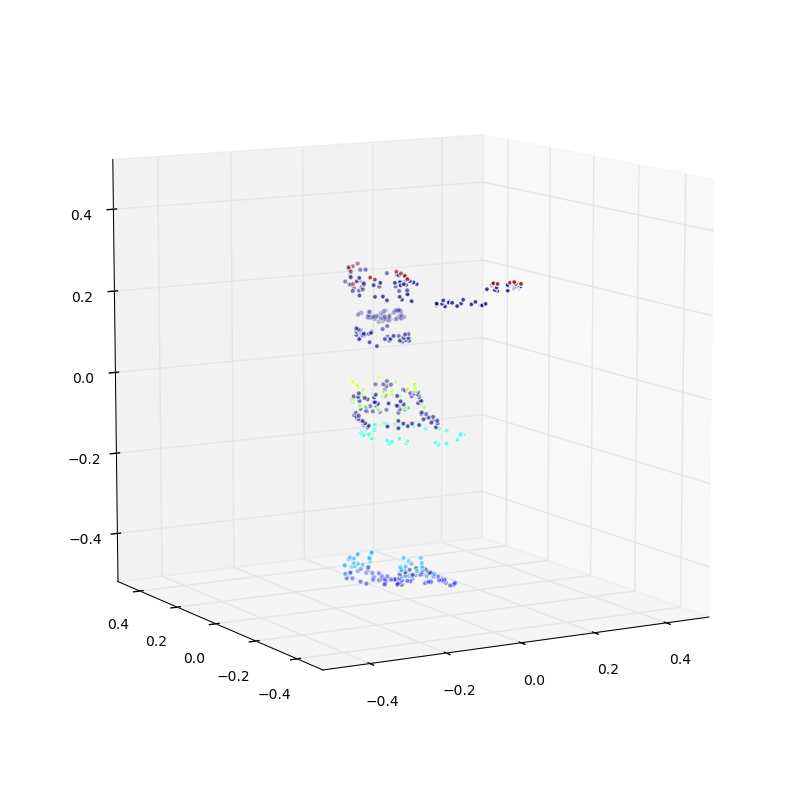

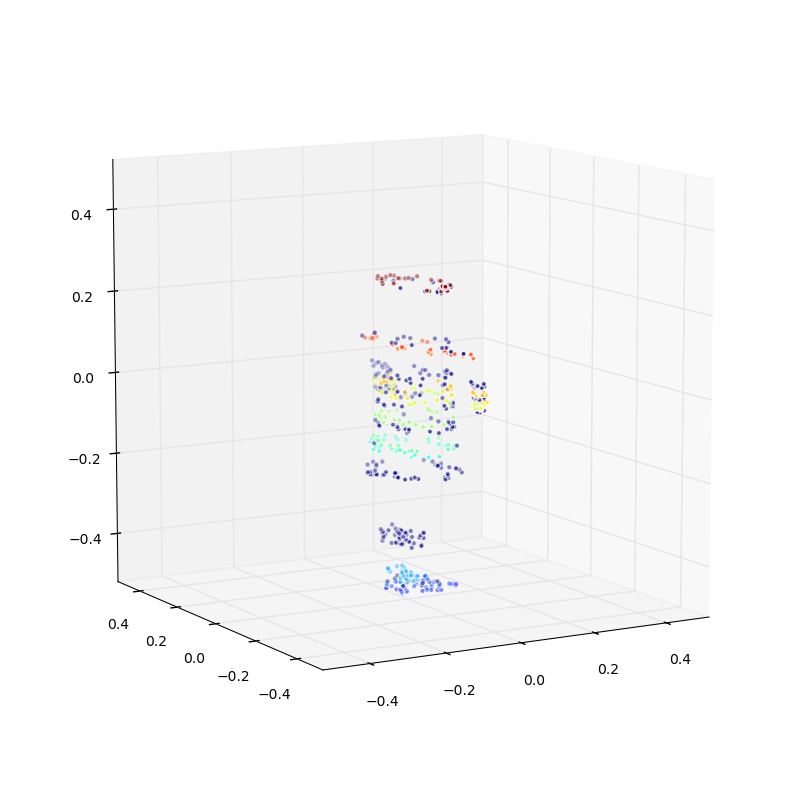

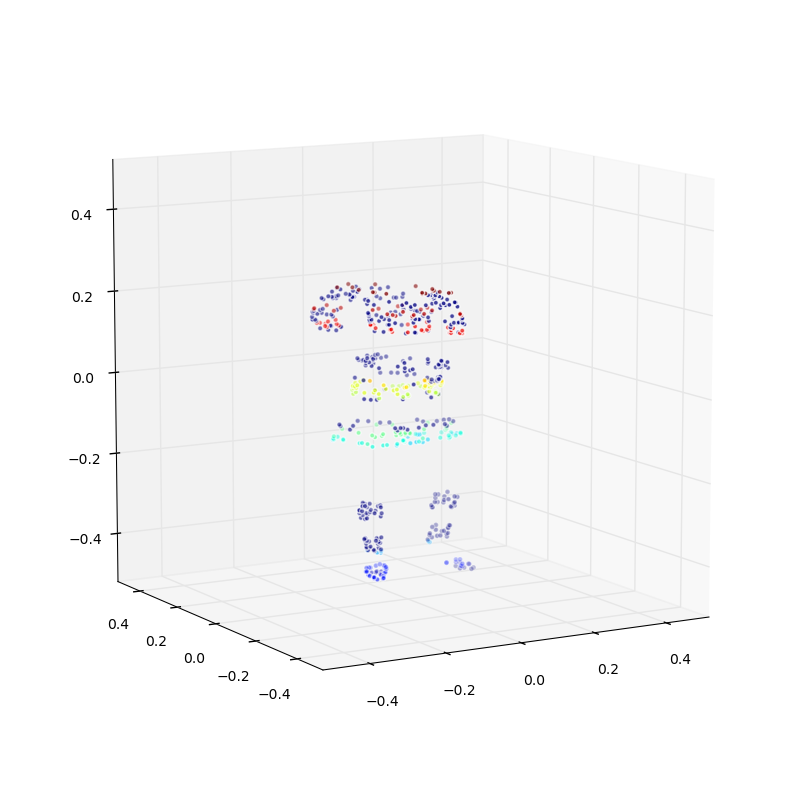

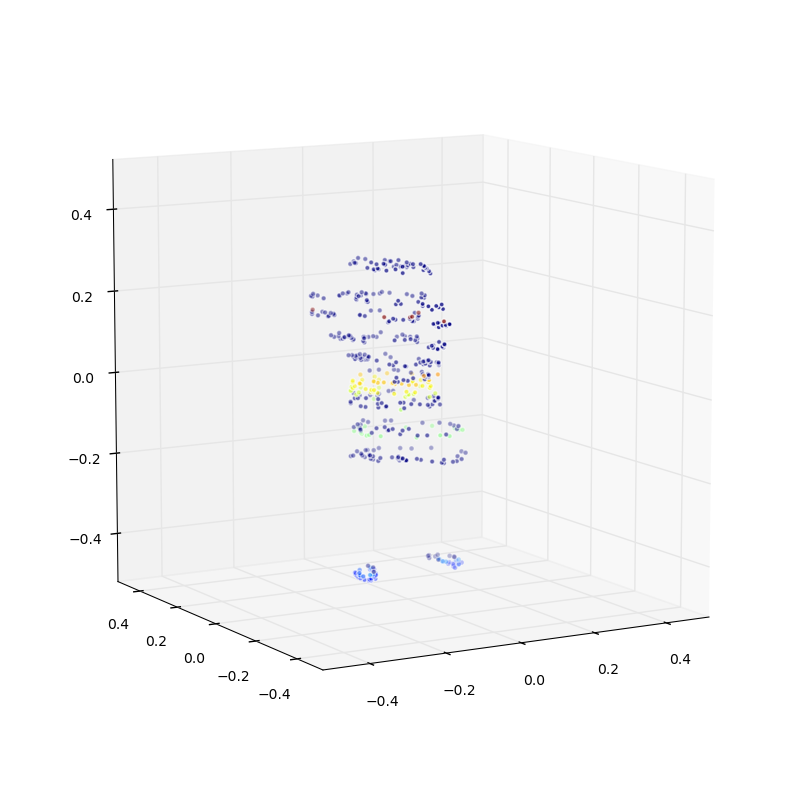

In [68]:
for i in range(len(pclouds_to_check)):
    non_zero = [np.any(indicators[i ,:, :], axis=1)]
    Point_Cloud(pclouds_to_check[i][non_zero]).plot(c=color[0][non_zero], s=50, color='w', figsize=(10,10));